In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import pandas as pd
import copy
%matplotlib inline

In [2]:
# read and process data
arr = []

with open('./0conf.csv') as f:
    for line in f.readlines():
        row = line.split(';')
        arr.append(row)
        
df = pd.DataFrame(arr, columns = ['node1_id','node2_id', 'node1_name', 'node2_name', 'node1_parent_id', 'node2_parent_id', 'node1_parent_name', 'node2_parent_name', 'edge confidence', 'edge weight (med nof)'])
df = df.drop(0)

node_map = {}

for index, row in df.iterrows():
    node_map[row['node1_id']] = row['node1_name']
    node_map[row['node2_id']] = row['node2_name']
    
edgelist = list(zip(df.node1_id, df.node2_id))

In [41]:
#define functions, for sure work
# Generate n random colors in hexadecimal format
def generatecolors(n):
    colors = ['#' + hex(secrets.randbits(24))[2:].zfill(6) for _ in range(n)]
    return colors

def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    if len(list(set(z.values()))) == 2:
        colors = ['blue','red']
    else:
        colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    
    
    node_colors = []
    for i in z.values():
        node_colors.append(colors[i])
       
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    nx.draw_networkx(G,with_labels=False,node_size=100,width=0.5,node_color=node_colors,alpha=1,edge_color = 'black') # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

def plot_CCDF(kis): # plotting function from ps1 
        # input : a list of degrees, e.g., from a networkx graph G
        # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1

        kmax = max(kis)

        # histogram and plot
        counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
        cumcounts = np.cumsum(counts)
        cumcounts = np.insert(cumcounts,0,0)
        plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
        plt.xlabel('Degree, k')
        plt.ylabel('Pr(K>=k)')
        plt.show()
        return

def get_hemi(name): # brain stem default to rh
    result = name.split('.')[0]
    if result == 'lh' or result == 'rh':
        return result
    elif 'left' in result:
        return 'lh'
    else: 
        return 'rh'

def tabulate_wk(G,z,c):
    # This function tabulates the w_rs and kappa_r auxiliary data structures for the DC-SBM
    #
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : wrs, kpr
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    wrs = np.zeros([c,c]) # count of stubs from group r to group s
    kpr = np.zeros([c,1]) # total degree of group r

    ##### do not modify above here #####
    
    
    ### YOUR CODE
    for edge in list(G.edges()):
        wrs[int(z[int(edge[0])])][int(z[int(edge[1])])] += 1
        wrs[int(z[int(edge[1])])][int(z[int(edge[0])])] += 1
        
    kpr = np.sum(wrs,axis=1)
        
    ##### do not modify below here #####

    return wrs,kpr

def random_z(n,c):
    # input  : number of nodes n, and number of groups c
    # output : returns a random partition in a dictionary z, where z_i = Uniform(0,c-1)

    import random as rnd
    rnd.seed()
    
    z = dict()

    ##### do not modify above here #####

    
    ### YOUR CODE
    for i in range(1,n+1):
        z[int(i)] = np.random.randint(low = 0, high = c)
        
    ##### do not modify below here #####
    return z

def dcsbm_LogL(wrs,kpr):
    # DO NOT MODIFY THIS FUNCTION
    # This function calculates the log-likelihood of the degree-corrected stochastic block model (DC-SBM)
    # See Eq. (9) in Lecture 6.
    #
    # input  : wrs is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    c = wrs.shape[1]  # number of groups
    
    logL = 0
    for r in range(c):
        for s in range(c):
            if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
    
    return logL
    # DO NOT MODIFY THIS FUNCTION

def plotLL(LL,pc,n):
    # DO NOT MODIFY THIS FUNCTION
    # This function makes a nice plot of the log-likelihood trajectory
    #
    # input  : LL is list of log-likelihood values of length (n+1)*(pc+1)
    #        : n, number of nodes
    #        : pc, number of phases in LL
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    tc  = len(LL)               # number of partitions considered in the LL trajectory

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    
    plt.plot(range(tc), LL, 'b.-', alpha=0.5)  # plot the log-likelihood trajectory
    for i in range(pc):                        # add vertical bars to demarcate phases, add black squares for phase-maxima
        plt.plot([(i)*(n+1),(i)*(n+1)],[min(LL),max(LL)], 'k--', alpha=0.5) # vertical bar
        LLp = LL[(i)*(n+1):(i+1)*(n+1)]
        b = LLp.index(max(LLp))
        plt.plot([(i)*(n+1)+b],[max(LLp)], 'ks', alpha=0.5)

    plt.ylabel('log-likelihood, DC-SBM')
    plt.xlabel('number of partitions considered')
    plt.show()
    
def makeAMove(G,z,c,f):
    # For each non 'frozen' node in the current partition, this function tries all (c-1) possible group moves for it
    # It returns the combination of [node i and new group r] that produces the best log-likelihood over the non-frozen set
    # input  : G, a graph
    #        : z, a partition of G's nodes
    #        : c, the number of groups
    #        : f, a binary labeling of frozen nodes
    # output : bestL, the best log-likelihood found
    #        : bestMove, [i,r] the node i and new group r to achieve bestL
    
    bestL = -np.inf            # the best log-likelihood over all considered moves
    for i in G.nodes(): # loop over all nodes i
        if f[int(i)] == 0:          # if i is not frozen
            s = int(z[int(i)])      #  get current label of i
            for r in range(c): #  then loop over all groups r
                #print(f'v[{i}] s = {s}, r={r}, {r!=s}') # for debugging

                ##### do not modify above here #####


                ## YOUR CODE
                if r != s:
                    z[int(i)] = r
                    wrs, kpr = tabulate_wk(G,z,c)
                    logL = dcsbm_LogL(wrs,kpr)
                    if logL > bestL:
                        bestL = logL
                        bestMove = [i,r]
            z[int(i)] = s
                ##### do not modify below here #####    
                
    return bestL,bestMove

def run_OnePhase(G,z0,c):
    # Runs one phase, initialized from partition z0
    # Returns the best partition found in the phase and the list of LogL values for all the phase's partitions
    # input  : G, a graph
    #        : z0, initial partition of G's nodes
    #        : c, the number of groups
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of LogL values for the n+1 partitions of this phase
    #        : halt, 1 if zstar=z0 (no better partition found)

    n    = G.order() # n, number of nodes
    LL   = []        # stores log-likelihoods over the entire algorithm (via .append)
    halt = 0         # flag: =0 if Lstar > L0 at the end of the phase; =1 if Lstar <= L0

    # initialize the phase
    wrs,kpr = tabulate_wk(G,z0,c)      # wrs, kpr, initial DC-SBM parameters
    L0      = dcsbm_LogL(wrs,kpr)      # store initial DC-SBM log-likelihood
    LL.append(L0)                      # track log-likelihood

    f     = dict.fromkeys(z0.keys(), 0) # initially, all nodes unfrozen (tricky python)
    t     = 0                          # number of frozen nodes in this phase
    Lstar = L0                         # initially, z0 has the best LogL
    zstar = copy.deepcopy(z0)          # and z0 is the best partition
    tstar = t                          # tstar = 0

    # loop over all the nodes in G, making greedy move for each
    zt = copy.deepcopy(z0)             # start the loop at z0
    for j in range(n):
        print(f'step {j}') # for debugging

        ##### do not modify above here #####

        
        ### YOUR CODE
        choiceL,choiceMove = makeAMove(G,zt,c,f)
        i,r = choiceMove[0],choiceMove[1]
        zt[int(i)] = r
        f[int(i)] = 1
        t+=1
        Lt = choiceL
        LL.append(choiceL)
        
        if Lt > Lstar:
            Lstar = Lt
            zstar = copy.deepcopy(zt)
            tstar = t
    if tstar==0:
        halt = 1
    #print(halt, Lstar, L0, z0, zstar)
        ##### do not modify below here #####

    return zstar,Lstar,LL,halt

def fit_DCSBM(G,c,T):
    # Runs the full locally greedy heuristic, with c groups
    # Returns the best partition found, its LogL, and the list of LogL values for all partitions considered
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of all LogL values considered
    #        : pc, the number of phases in LL

    
    # 1.0 locally greedy heuristic setup
    n  = G.order() # n, number of nodes
    LL   = []      # log-likelihoods over the entire algorithm (concat via .extend)
    halt = 0       # convergence flag

    # 2.0 generate initial partition, calculate wrs,kpr, and store the loglikelihood in Lt
    zt      = random_z(n,c)       # z0, initial partition
    wrs,kpr = tabulate_wk(G,zt,c) # wrs, kpr, initial DC-SBM parameters
    Lt      = dcsbm_LogL(wrs,kpr) # store initial DC-SBM log-likelihood

    # 3.0 the main loop
    pc = 0  # counter for number of phases completed
    while not halt:
        # 3.1 visualization of this phase's initial partition
        print(f'phase[{pc}] z[0], logL = {Lt}')
        drawGz(G,zt)

        ##### do not modify above here #####

        
        ### YOUR CODE
        zstar, Lstar, phaseLL, halt = run_OnePhase(G,zt,c)
        LL.extend(phaseLL)
        zt = copy.deepcopy(zstar)
        Lt = Lstar
        if pc >= T:
            halt = 1
        else:
            pc+=1
            
        ##### do not modify below here #####
    
    print(f' --> WE HAVE CONVERGENCE <-- ') # a friendly alert
    return zstar,Lstar,LL,pc

def fit_DCSBM_reps(G,c,T,reps):
    Lbest = -np.inf
    for i in range(reps):
        zstar,Lstar,LL,pc = fit_DCSBM(G,c,T)
        if Lstar > Lbest:
            zbest = copy.deepcopy(zstar)
            Lbest = Lstar
            LLbest = LL
            pcbest = pc
            
    return zbest,Lbest,LLbest,pcbest

def parse_jaccard(z_0, z_1):
    denom = len(z_0.keys())
    num = 0
    for k in z_0:
        if z_0[int(k)] == z_1[int(k)]:
            num += 1
    return (num/denom)

In [4]:
G = nx.from_edgelist(edgelist)
#node_list = []
#z = {}

#for node in nx.nodes(G):
    #node_list.append(get_hemi(node_map[node]))
    #z[node] = get_hemi(node_map[node])

n = len(nx.nodes(G)) # num nodes 
m = len(nx.edges(G)) # num edges
kmean = (2*m)/n # mean degree formula for undirected graph
C = nx.transitivity(G) # clustering coeffcient 
ellmean = nx.average_shortest_path_length(G) # ellmean using networkx function
#print(node_list)

phase[0] initial z, logL = -841319.5480989767


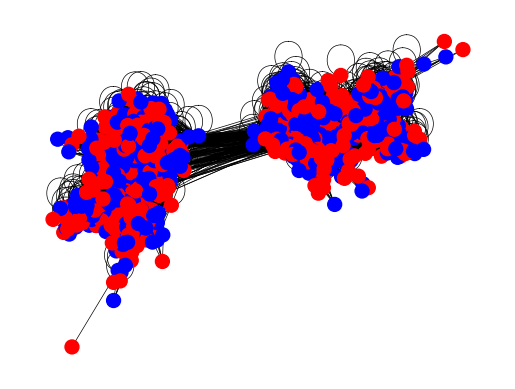

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85
step 86
step 87
step 88
step 89
step 90
step 91
step 92
step 93
step 94
step 95
step 96
step 97
step 98
step 99
step 100
step 101
step 102
step 103
step 104
step 105
step 106
step 107
step 108
step 109
step 110
step 111
step 112
step 113
step 114
step 115
step 116
step 117
step 118
step 119
step 120
step 121
step 122
ste

step 923
step 924
step 925
step 926
step 927
step 928
step 929
step 930
step 931
step 932
step 933
step 934
step 935
step 936
step 937
step 938
step 939
step 940
step 941
step 942
step 943
step 944
step 945
step 946
step 947
step 948
step 949
step 950
step 951
step 952
step 953
step 954
step 955
step 956
step 957
step 958
step 959
step 960
step 961
step 962
step 963
step 964
step 965
step 966
step 967
step 968
step 969
step 970
step 971
step 972
step 973
step 974
step 975
step 976
step 977
step 978
step 979
step 980
step 981
step 982
step 983
step 984
step 985
step 986
step 987
step 988
step 989
step 990
step 991
step 992
step 993
step 994
step 995
step 996
step 997
step 998
step 999
step 1000
step 1001
step 1002
step 1003
step 1004
step 1005
step 1006
step 1007
step 1008
step 1009
step 1010
step 1011
step 1012
step 1013
step 1014


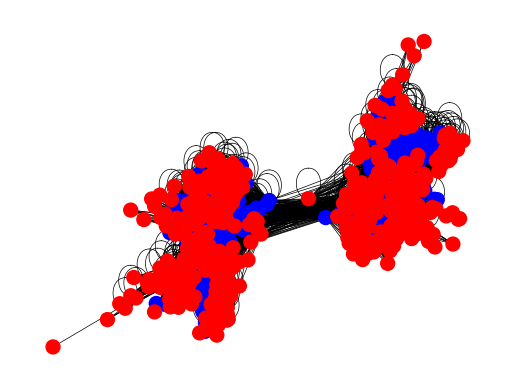

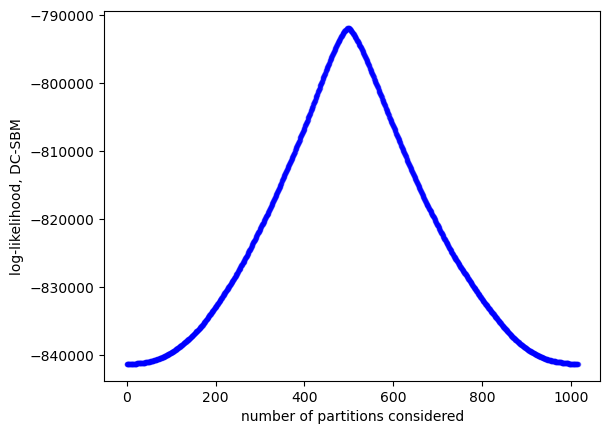

In [42]:
c = 2
z0 = random_z(n,c)
wrs,kpr = tabulate_wk(G,z0,c)
L0 = dcsbm_LogL(wrs,kpr)
print(f'phase[0] initial z, logL = {L0}')
drawGz(G,z0)

zstar,Lstar,LL,halt = run_OnePhase(G,z0,c)
drawGz(G,zstar)
plotLL(LL,0,G.order())

In [57]:
df.head()

,node1_id,node2_id,node1_name,node2_name,node1_parent_id,node2_parent_id,node1_parent_name,node2_parent_name,edge confidence,edge weight (med nof)
1,559,559,lh.rostralmiddlefrontal_15,lh.rostralmiddlefrontal_15,48,48,ctx-lh-rostralmiddlefrontal,ctx-lh-rostralmiddlefrontal,16,1.000000\n
2,559,565,lh.rostralmiddlefrontal_15,lh.rostralmiddlefrontal_22,48,48,ctx-lh-rostralmiddlefrontal,ctx-lh-rostralmiddlefrontal,58,1.000000\n
3,559,560,lh.rostralmiddlefrontal_15,lh.rostralmiddlefrontal_13,48,48,ctx-lh-rostralmiddlefrontal,ctx-lh-rostralmiddlefrontal,53,1.000000\n
4,559,1004,lh.rostralmiddlefrontal_15,lh.insula_4,48,75,ctx-lh-rostralmiddlefrontal,ctx-lh-insula,35,1.000000\n
5,559,580,lh.rostralmiddlefrontal_15,lh.rostralmiddlefrontal_3,48,48,ctx-lh-rostralmiddlefrontal,ctx-lh-rostralmiddlefrontal,10,1.000000\n
